In [324]:
# Import required libraries
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
from scipy import signal

from scipy import fftpack

In [79]:
# df = pd.read_csv('HadCRUT/HadCRUT.4.6.0.0.monthly_sh.1.txt', delim_whitespace=True, header=None)
df = pd.read_csv('opsd_germany_daily.csv')

Column 1 is the date.
Column 2 is the median of the 100 ensemble member time series.
Columns 3 and 4 are the lower and upper bounds of the 95% confidence interval of bias uncertainty computed from the 100 member ensemble.
Columns 5 and 6 are the lower and upper bounds of the 95% confidence interval of measurement and sampling uncertainties around the ensemble median. These are the combination of fully uncorrelated measurement and sampling uncertainties and partially correlated uncertainties described by the HadCRUT4 error covariance matrices.
Columns 7 and 8 are the lower and upper bounds of the 95% confidence interval of coverage uncertainties around the ensemble median.
Columns 9 and 10 are the lower and upper bounds of the 95% confidence interval of the combination of measurement and sampling and bias uncertainties.
Columns 11 and 12 are the lower and upper bounds of the 95% confidence interval of the combined effects of all the uncertainties described in the HadCRUT4 error model (measurement and sampling, bias and coverage uncertainties).


In [80]:
#df = df[[0, 1]]
#df.columns = ['date', 'median_temp']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(df['Date'], inplace=True)

df = df[df['Date'] > '2012'].copy()

In [81]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
Date,,,,,
2012-01-02,2012-01-02,1269.581,207.327,6.574,213.901
2012-01-03,2012-01-03,1334.745,473.468,24.679,498.147
2012-01-04,2012-01-04,1347.136,499.804,14.681,514.485
2012-01-05,2012-01-05,1376.658,523.851,5.071,528.922
2012-01-06,2012-01-06,1291.215,286.265,13.160,299.425


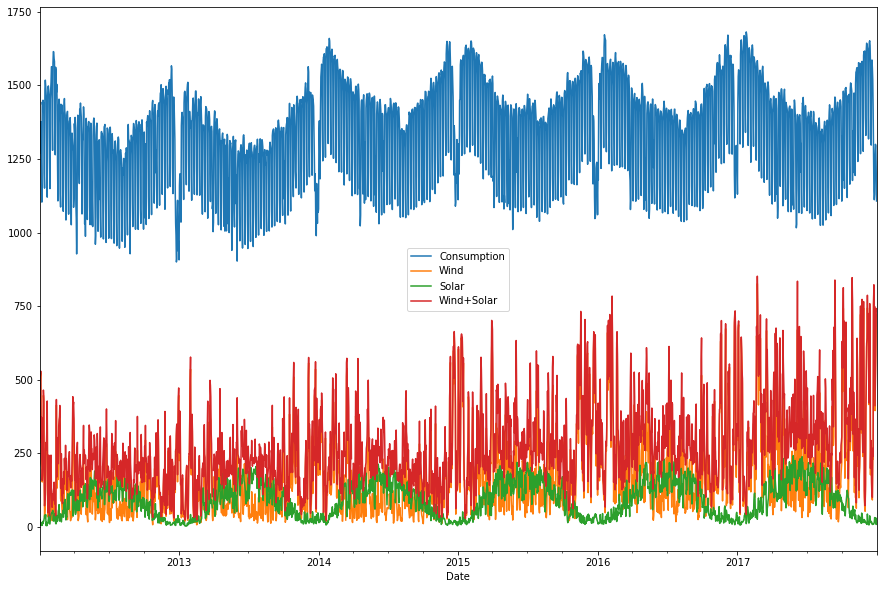

In [82]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 10)
#df['Consumption'].plot(ax=ax)
df[['Consumption', 'Wind', 'Solar', 'Wind+Solar']].plot(ax=ax)
plt.savefig('resample_needed.png')

In [83]:
df_weekly = df.resample('W').mean()

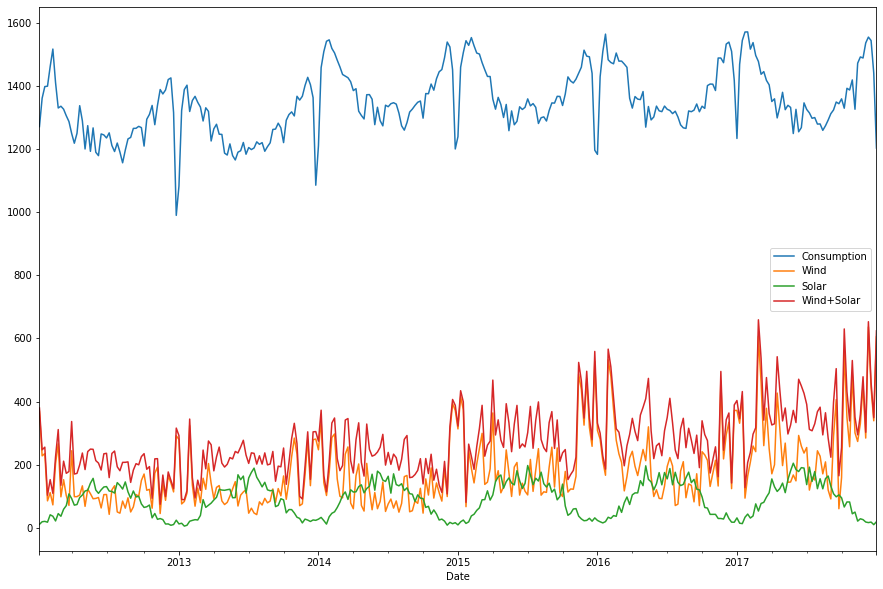

In [84]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 10)
df_weekly.plot(ax=ax)
plt.savefig('weekly_resample.png')

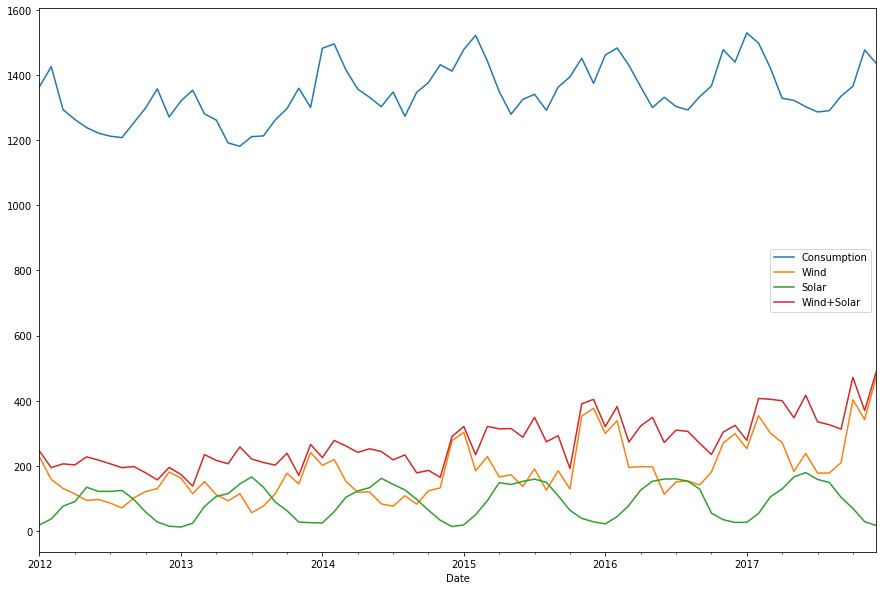

In [85]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 10)
df.resample('M').mean().plot(ax=ax)
plt.savefig('monthly_resample.png')

In [142]:
def df_fuller(timeseries, window_size=12, filename=None):    
    #Determing rolling statistics
    plt.figure(figsize=(15,10))
    rolmean = timeseries.rolling(window_size).mean()
    rolstd = timeseries.rolling(window_size).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=window_size*4)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [106]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
Date,,,,,
2012-01-02,2012-01-02,1269.581,207.327,6.574,213.901
2012-01-03,2012-01-03,1334.745,473.468,24.679,498.147
2012-01-04,2012-01-04,1347.136,499.804,14.681,514.485
2012-01-05,2012-01-05,1376.658,523.851,5.071,528.922
2012-01-06,2012-01-06,1291.215,286.265,13.160,299.425


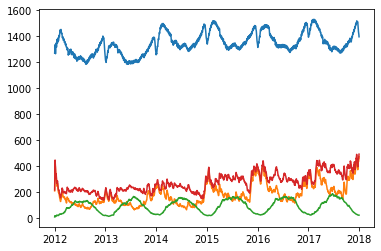

In [119]:
plt.plot(df[['Consumption', 'Wind', 'Solar', 'Wind+Solar']].ewm(alpha=0.05).mean())

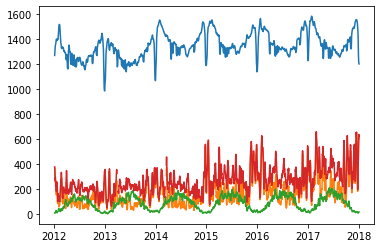

In [117]:
plt.plot(df[['Consumption', 'Wind', 'Solar', 'Wind+Solar']].rolling(7).mean())

Date
2012-01-02    213.901
2012-01-03    498.147
2012-01-04    514.485
2012-01-05    528.922
2012-01-06    299.425
2012-01-07    372.403
2012-01-08    229.291
               ...   
2017-12-25    603.575
2017-12-26    748.376
2017-12-27    411.037
2017-12-28    520.586
2017-12-29    614.131
2017-12-30    728.714
2017-12-31    741.156
Name: Wind+Solar, Length: 2186, dtype: float64


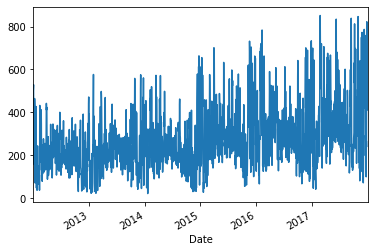

In [132]:
df_weekly = np.log(df_weekly)
dft = df['Wind+Solar'].dropna()
print(dft)
dft.plot()

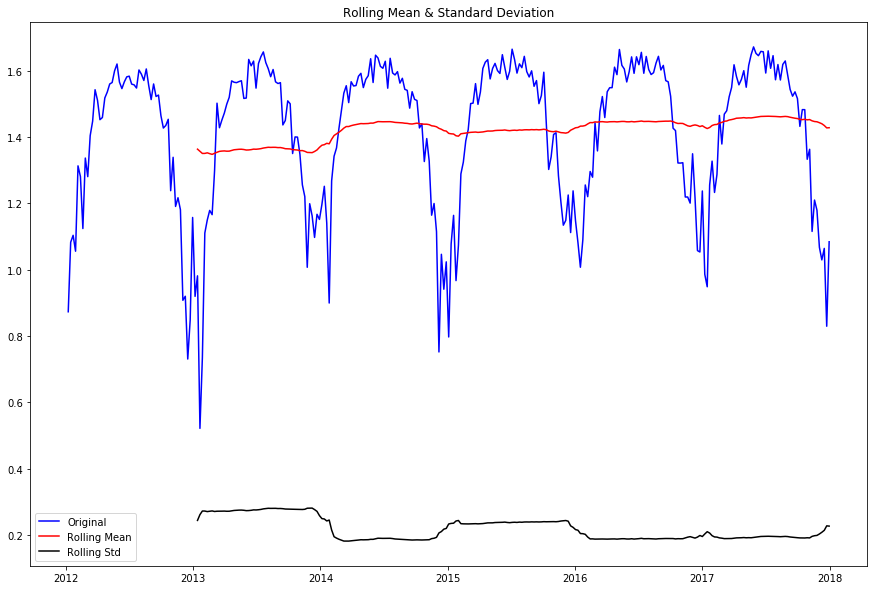

Results of Dickey-Fuller Test:


ValueError: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors

In [212]:
df_fuller(df_weekly['Solar'], 54)

In [156]:
df_weekly_dtrnd = df_weekly - df_weekly.rolling(4).mean()
df_weekly_dtrnd.dropna(inplace=True)

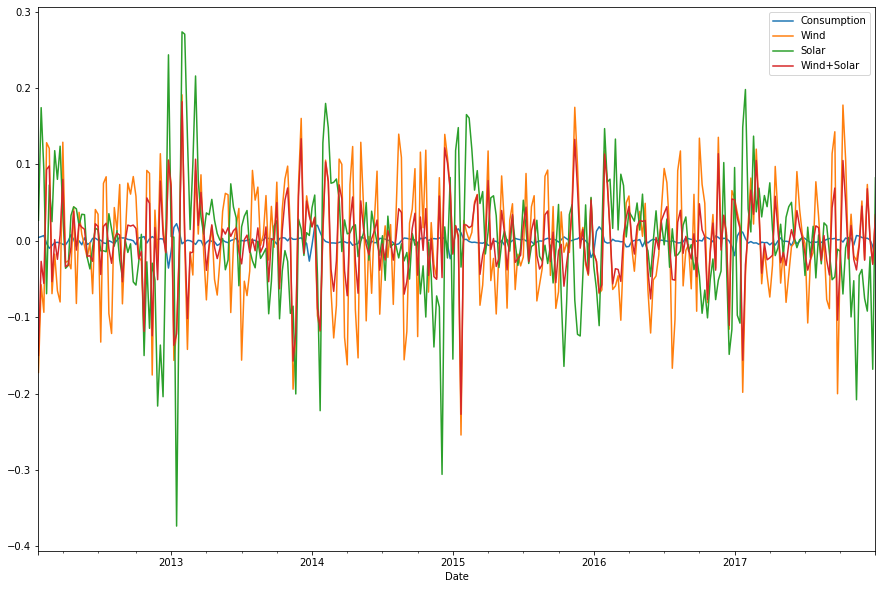

In [157]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 10)
df_weekly_dtrnd.plot(ax=ax)

<Figure size 1080x720 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

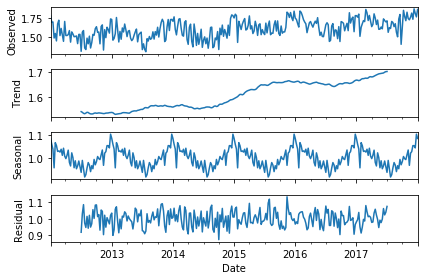

In [234]:
#df_fuller(df_weekly_dtrnd['Wind+Solar'], 12)
plt.figure(figsize=(15,10))
result = seasonal_decompose(df_weekly['Wind'], model='multiplicative')
plt.figure(figsize=(10,15))
result.plot()
plt.savefig('decomp_wind.png')

In [336]:
dfa = pd.read_csv('airline_passengers.csv')
dfa['Month'] = pd.to_datetime(dfa['Month'], format='%Y-%m')
dfa.columns = ['date', 'passengers']
dfa.set_index('date', inplace=True)
print(dfa.passengers.var())
#dfa['passengers'] = np.log(dfa['passengers'])
print(dfa.passengers.var())

14391.9172008547
14391.9172008547


In [303]:
dfa

,passengers
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212
...,...
1960-06-01,6.282267


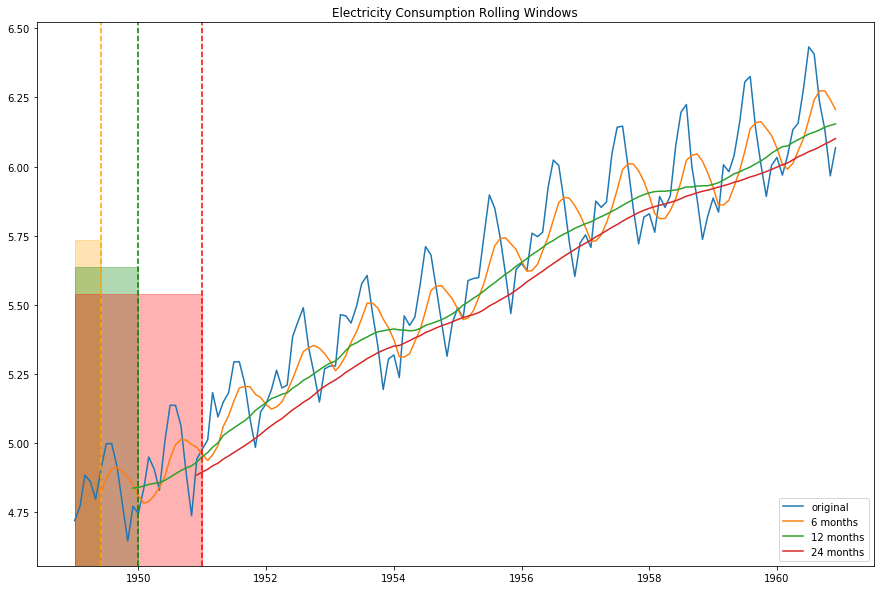

In [307]:
plt.figure(figsize=(15,10))
plt.plot(dfa, label='original')
rolmean = dfa.rolling(12).mean()
rolmean24 = dfa.rolling(24).mean()
rolmean6 = dfa.rolling(6).mean()
rolmean36 = dfa.rolling(36).mean()
plt.plot(rolmean6, label='6 months')
plt.plot(rolmean, label='12 months')
plt.plot(rolmean24, label='24 months')
# plt.plot(rolmean36, label='36 months')
plt.title('Electricity Consumption Rolling Windows')
plt.axvspan('1949-01-01', '1949-06-01', alpha=0.3, ymax=0.6, color='orange')
plt.axvline('1949-06-01', color='orange', linestyle='--')

plt.axvspan('1949-01-01', '1950-01-01', ymax=0.55, alpha=0.3, color='green')
plt.axvline('1950-01-01', color='green', linestyle='--')

plt.axvspan('1949-01-01', '1951-01-01', ymax=0.5, alpha=0.3, color='red')
plt.axvline('1951-01-01', color='red', linestyle='--')


plt.legend()
plt.savefig('airline_windows.png')

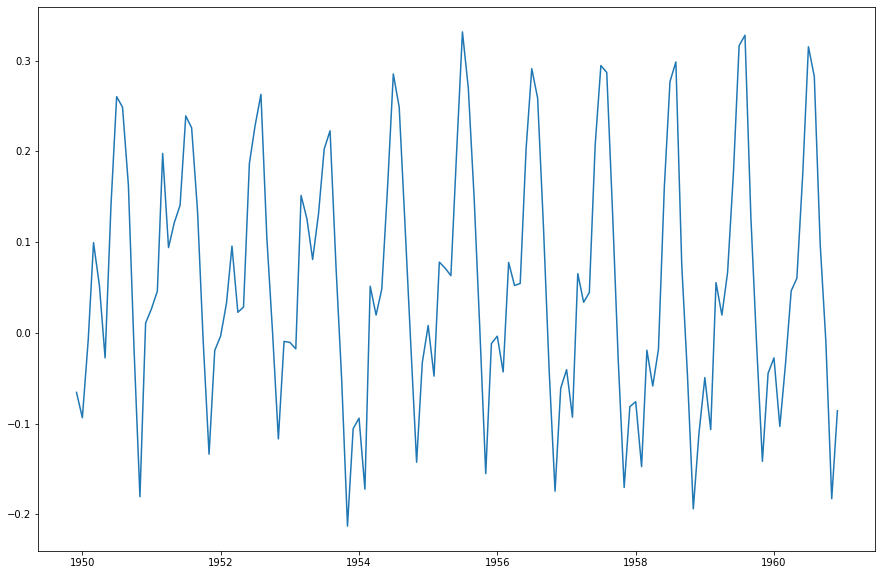

In [16]:
plt.figure(figsize=(15,10))
dfa_dtrnd = dfa - dfa.rolling(12).mean()
dfa_dtrnd.dropna(inplace=True)
plt.plot(dfa_dtrnd)
plt.savefig('airline_detrend.png')

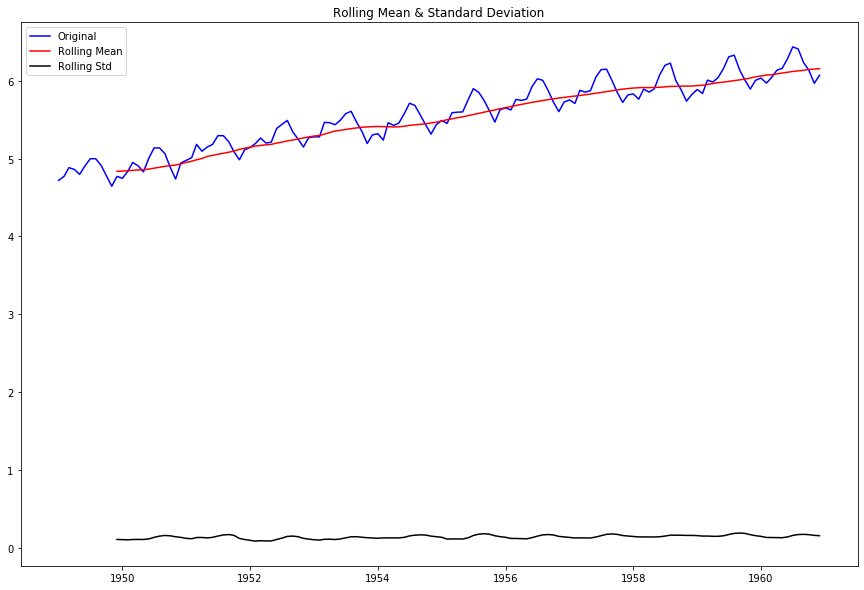

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
Length: 7, dtype: float64


In [18]:
df_fuller(dfa['passengers'], filename='stationarity_passengers.png')

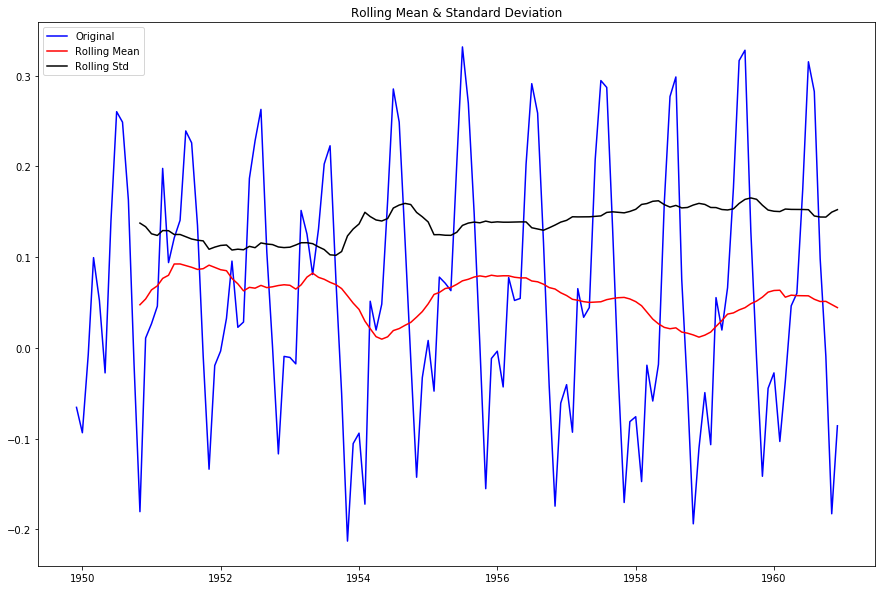

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
Length: 7, dtype: float64


In [19]:
df_fuller(dfa_dtrnd['passengers'], filename='passengers_detrended.png')

<Figure size 1080x720 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

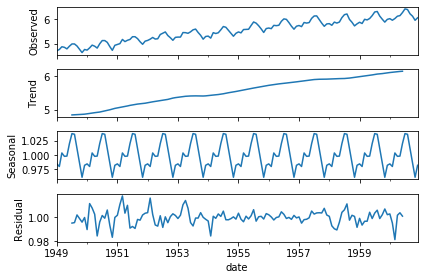

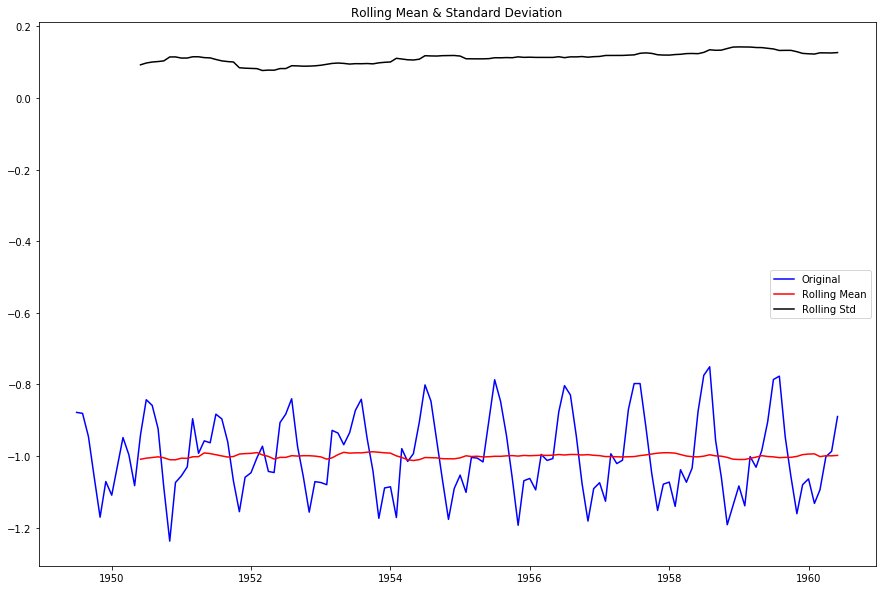

Results of Dickey-Fuller Test:
Test Statistic                  -4.763795
p-value                          0.000064
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
Length: 7, dtype: float64


In [21]:
#series = pd.read_csv('airline-passengers.csv', header=0, index_col=0, parse_dates=True,
#squeeze=True)
plt.figure(figsize=(15,10))
result = seasonal_decompose(dfa, model='multiplicative')
plt.figure(figsize=(10, 15))
result.plot()
plt.savefig('multiplicative_passengers.png')
#p
#df_tmp = dfa['passengers'] - result.seasonal['passengers'] - result.trend['passengers']
df_tmp= dfa - result.seasonal - result.trend
#print(df_tmp)
df_fuller(df_tmp[df_tmp['passengers'].notnull()]['passengers'], filename='residuals_passengers.png')

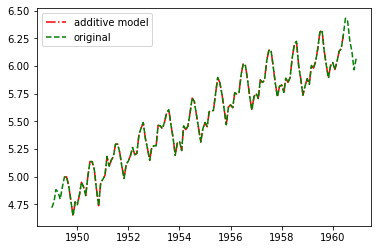

In [49]:
df_tmp= result.seasonal * result.trend * result.resid
#df_tmp.plot()
#dfa.plot()

plt.plot(df_tmp['passengers'], color='red', linestyle='dashdot', label='additive model')
plt.plot(dfa['passengers'], linestyle='--', color='green', label='original')
plt.legend()

<Figure size 1080x720 with 0 Axes>

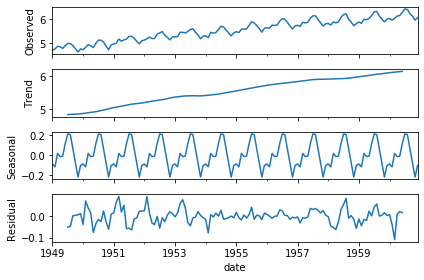

<Figure size 1080x720 with 0 Axes>

In [55]:
#chec kthe mult vs addi models
#mult = seasonal_decompose(dfa, model='multiplicative')
#fig, ax = plt.subplots(1,1)
#ig.set_size_inches(15, 10)
add_ = seasonal_decompose(dfa, model='additive')
plt.figure(figsize=(15,10))
add_.plot()
plt.figure(figsize=(15,10))


plt.savefig('additive_passengers.png')

In [54]:
add_.plot()

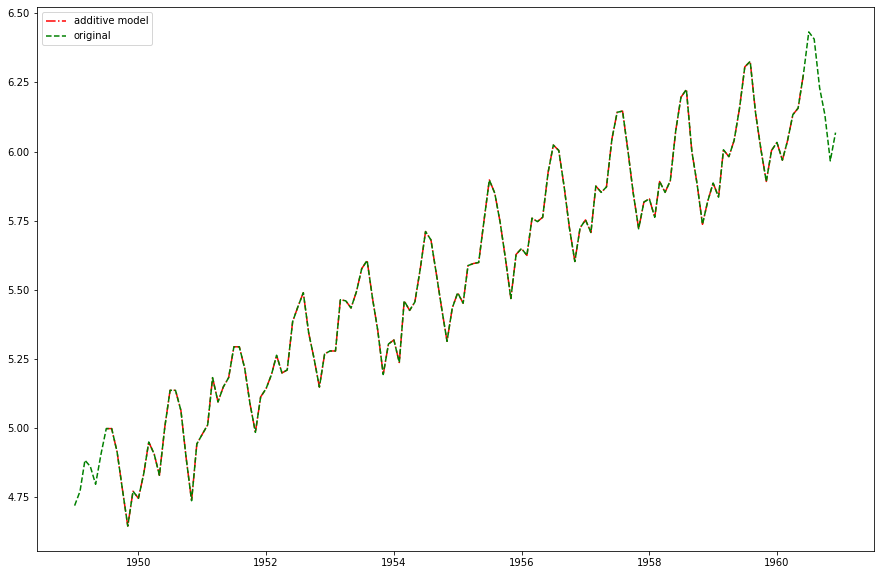

In [65]:
df_tmp= add_.seasonal + add_.trend + add_.resid
plt.figure(figsize=(15,10))
plt.plot(df_tmp['passengers'], color='red', linestyle='dashdot', label='additive model')
plt.plot(dfa['passengers'], linestyle='--', color='green', label='original')
plt.legend()
plt.savefig('additive_model_check.png')

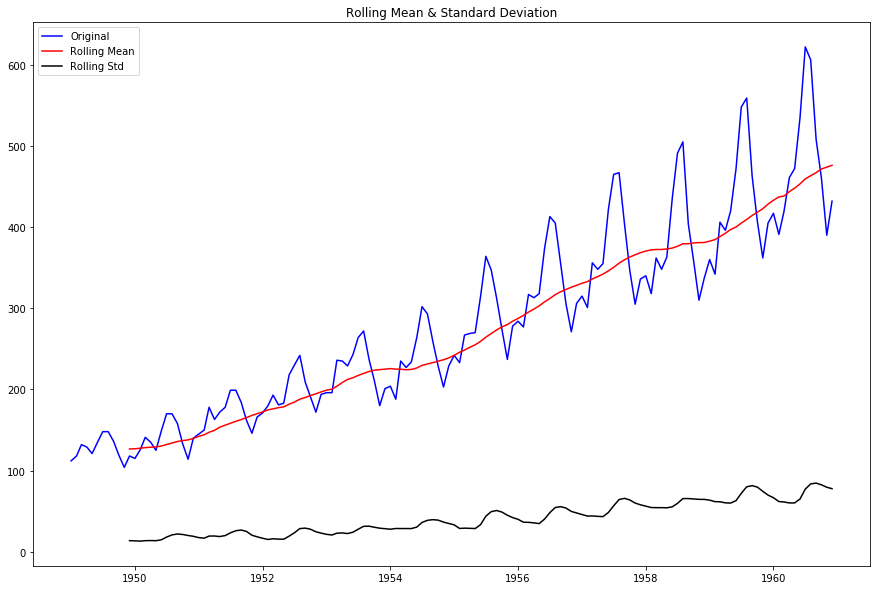

Results of Dickey-Fuller Test:
Test Statistic                  2.713900
p-value                         0.999088
#Lags Used                     45.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
Length: 7, dtype: float64


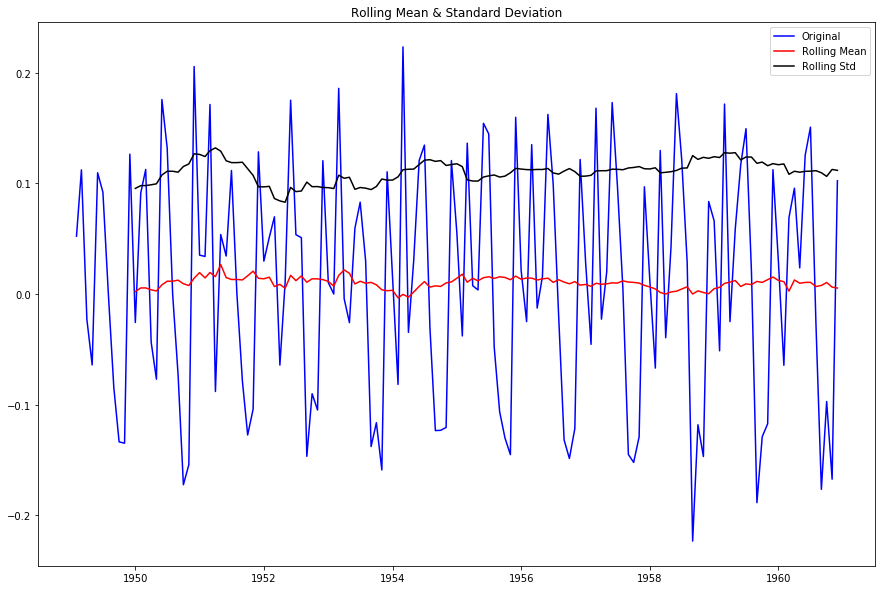

Results of Dickey-Fuller Test:
Test Statistic                  -2.142089
p-value                          0.227930
#Lags Used                      24.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
Length: 7, dtype: float64


In [342]:
dfa_log = np.log(dfa)
#print(dfa_log.var())
#print(dfa.var())
df_fuller(dfa['passengers'])
df_fuller((dfa_log['passengers'] - dfa_log['passengers'].shift(1)).dropna())

In [326]:
kpss(dfa_log['passengers'])

/Users/tim26/venvs/python37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(1.0488491819943184,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
# plot the autocorrelation of a differenced random walk
# line plot
autocorrelation_plot(diff)
pyplot.show()

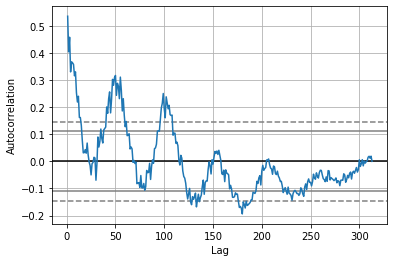

In [241]:
def plot_auto(x_in, title='', filename=None):
    
    fig, ax = plt.subplots()
    # plt.figure(figsize=(15,10))
    autocorrelation_plot(x_in, ax=ax)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    

#for label in ['Consumption', 'Wind', 'Solar', 'Wind+Solar']:
#    plot_auto(df[label])
plot_auto(df.resample('W').mean()['Wind'])
#df.head()

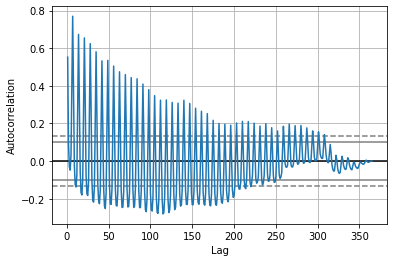

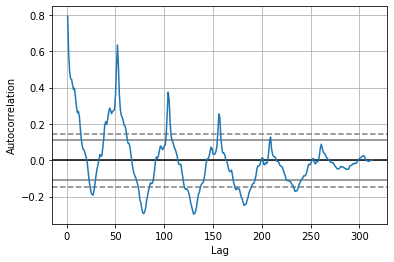

In [242]:
plot_auto(df.iloc[:365]['Consumption'], title='daily consumption autocorrelation', filename='consumption_autocorr.png')

plot_auto(df_weekly['Consumption'], title='weekly consumption autocorrelation', filename='consumption_weekly_autocorr.png')

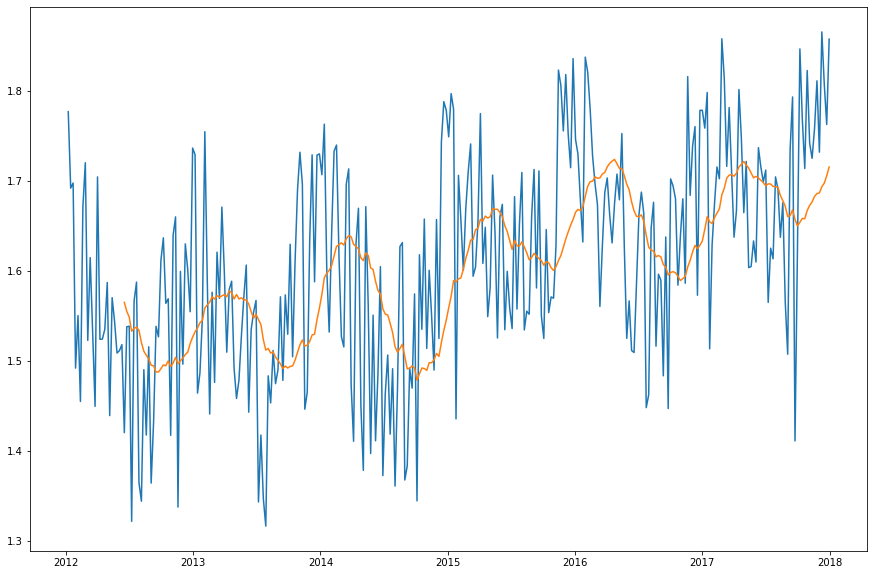

In [230]:
plt.figure(figsize=(15,10))
plt.plot(df_weekly[['Wind']])
rolmean = df_weekly[['Wind']].rolling(24).mean()
plt.plot(rolmean)
#plt.savefig('airline_trend.png')

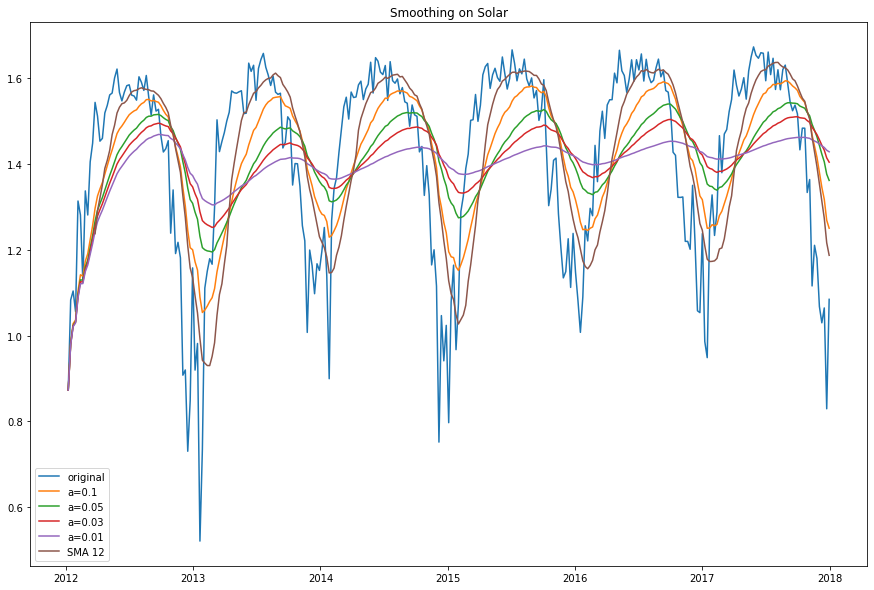

In [233]:
col = 'Solar'
plt.figure(figsize=(15,10))
plt.plot(df_weekly[col], label='original')
a1 = df_weekly[col].ewm(alpha=0.1).mean()
plt.plot(a1, label='a=0.1')
a5 = df_weekly[col].ewm(alpha=0.05).mean()
plt.plot(a5, label='a=0.05')
a3 = df_weekly[col].ewm(alpha=0.03).mean()
plt.plot(a3, label='a=0.03')
a01 = df_weekly[col].ewm(alpha=0.01).mean()
plt.plot(a01, label='a=0.01')
rolmean = df_weekly[col].rolling(12).mean()
plt.plot(rolmean, label='SMA 12')
plt.title('Smoothing on ' + col)
plt.legend()
plt.savefig(col+'_smooth.png')

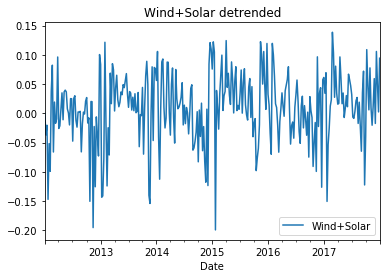

In [198]:
#plt.f
(df_weekly[['Wind+Solar']] - a3).plot()
plt.title('Wind+Solar detrended')

plt.savefig('wind_solar_detrend.png')

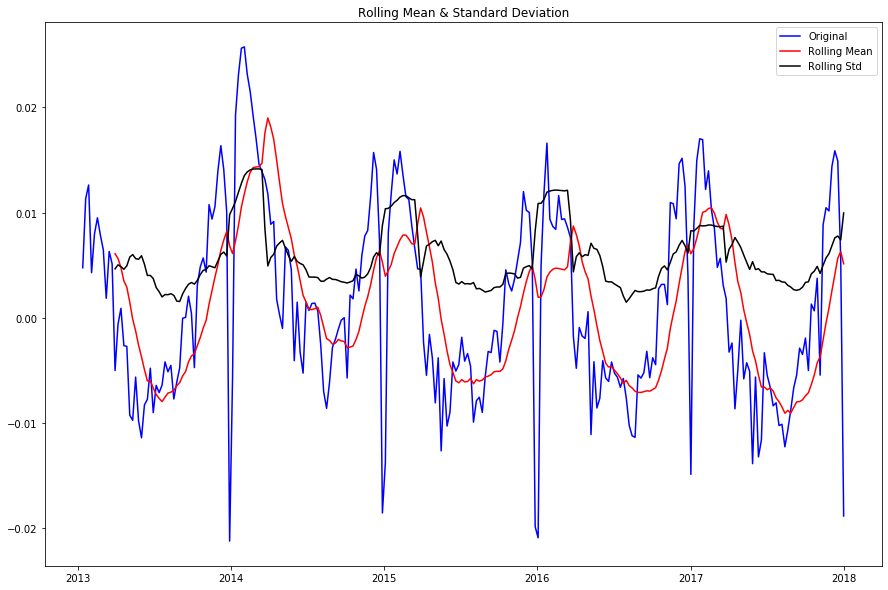

Results of Dickey-Fuller Test:
Test Statistic                  -3.784680
p-value                          0.003068
#Lags Used                       4.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
Length: 7, dtype: float64


In [323]:
rolmean = df_weekly['Consumption'].rolling(54).mean()
df_d = df_weekly['Consumption'] - rolmean
df_fuller(df_d.dropna(), filename='detrend_consumption.png')

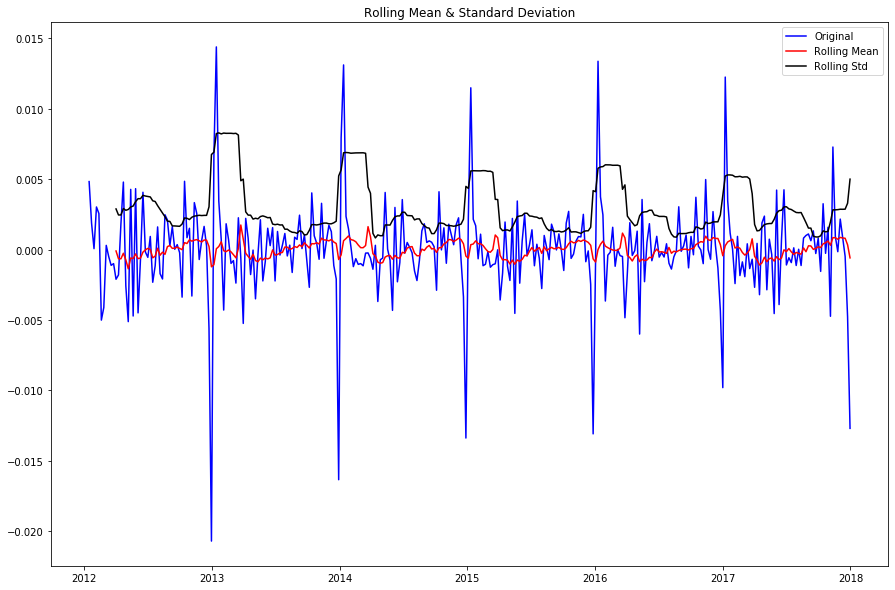

Results of Dickey-Fuller Test:
Test Statistic                -6.980404e+00
p-value                        8.220249e-10
#Lags Used                     3.700000e+01
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
Length: 7, dtype: float64


In [338]:
df_fuller((np.log(df_weekly['Consumption']) - np.log(df_weekly['Consumption']).shift()).dropna())

In [279]:
def plot_fft(x_in, f=50, filename=None):
    f_s = 1/f
    X = fftpack.fft(x_in)
    freqs = fftpack.fftfreq(len(x_in)) * f_s
    f, (ax0, ax1) = plt.subplots(2, 1)

    ax0.plot(x_in)
    ax0.set_ylim(0.0, 1.1)

    ax1.plot(fftpack.fftfreq(len(x_in)), np.abs(X))
    ax1.set_ylim(0, 10);
    if filename is not None:
        plt.savefig(filename)

#fig, ax = pl
def plot_stft(X, nperseg=256, fs=1/50, title='', filename=None):
    f, t, Zxx = signal.stft(X, fs=fs, nperseg=nperseg)
    amp = f.max()*2
    amp = np.abs(Zxx).max()/8
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    #plt.plot(f.max()*df['gps_speed(m/s)']/df['gps_speed(m/s)'].max())
    if filename is not None:
        plt.savefig(filename)
    plt.show()


def plot_spectrogram(x_in, filename=None):
    freqs, times, spectrogram = signal.spectrogram(x_in, fs=1/50, window='hann')

    plt.figure(figsize=(5, 4))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram')
    plt.ylabel('Frequency band')
    plt.xlabel('Time window')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    
def plot_density(x_in, title='', fs=1/50, filename=None):
    freqs, psd = signal.welch(x_in, fs=fs, )
    plt.figure(figsize=(5, 4))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density - ' + title)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        
        
def plot_ts(x_in, title='', filename=None):
    plt.figure(figsize=(15, 10))
    x_in.plot()
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)

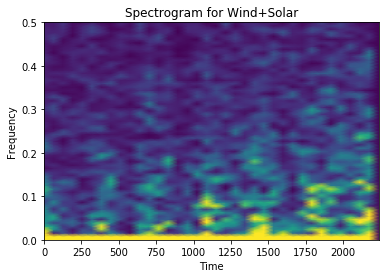

In [347]:
plot_stft(df['Wind+Solar'].dropna(), 128, fs=1, title='Spectrogram for Wind+Solar', filename='spectrogram_wind_solar.png')

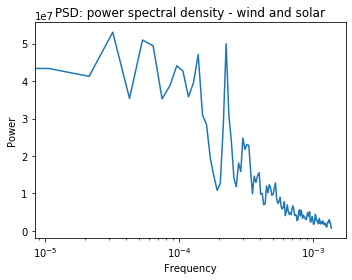

In [284]:
plot_density(df['Wind+Solar'].dropna(), fs=1/365, title='wind and solar', filename='psd_wind_solar.png')

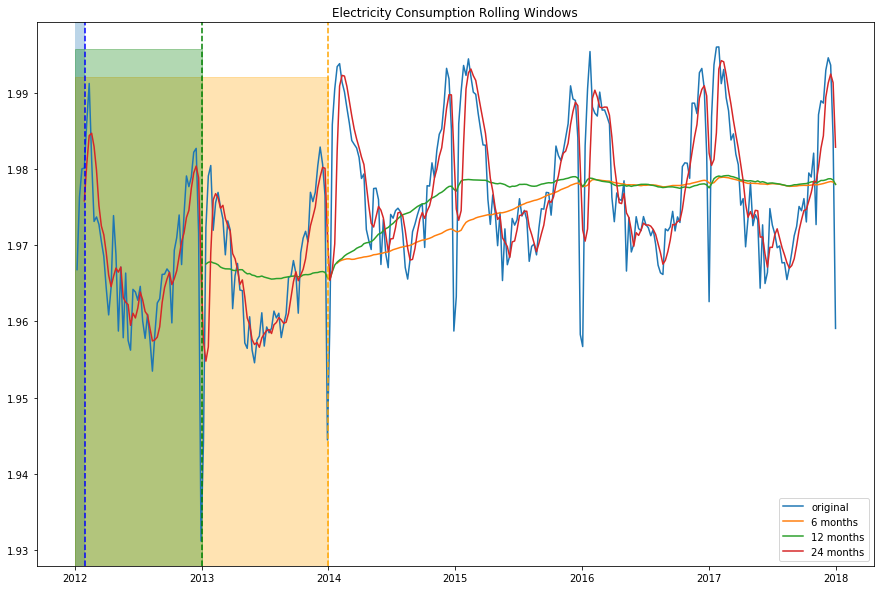

In [308]:
plt.figure(figsize=(15,10))
plt.plot(df_weekly['Consumption'], label='original')
rolmean = df_weekly['Consumption'].rolling(54).mean()
rolmean24 = df_weekly['Consumption'].rolling(4).mean()
rolmean6 = df_weekly['Consumption'].rolling(108).mean()
#rolmean36 = df_weekly['Consumption'].rolling(365).mean()
plt.plot(rolmean6, label='6 months')
plt.plot(rolmean, label='12 months')
plt.plot(rolmean24, label='24 months')
# plt.plot(rolmean36, label='36 months')
plt.title('Electricity Consumption Rolling Windows')
plt.axvspan('2012-01', '2012-02', alpha=0.3)
plt.axvline('2012-02', color='blue', linestyle='--')

plt.axvspan('2012-01', '2014-01', ymax=0.9, alpha=0.3, color='orange')
plt.axvline('2014-01', color='orange', linestyle='--')

plt.axvspan('2012-01', '2013-01', ymax=0.95, alpha=0.3, color='green')
plt.axvline('2013-01', color='green', linestyle='--')


plt.legend()
plt.savefig('consumption_windows.png')

In [309]:
dfa.tail()

,passengers
date,
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398
1960-11-01,5.966147
1960-12-01,6.068426


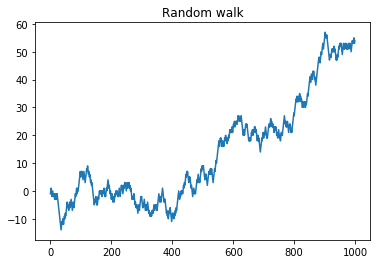

In [349]:
from random import seed
from random import random
from matplotlib import pyplot
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
	movement = -1 if random() < 0.5 else 1
	value = random_walk[i-1] + movement
	random_walk.append(value)
plt.title('Random walk')
plt.plot(random_walk)
plt.savefig('random_walk.png')
plt.show()

In [358]:
rw = pd.DataFrame(random_walk, columns=['value'])

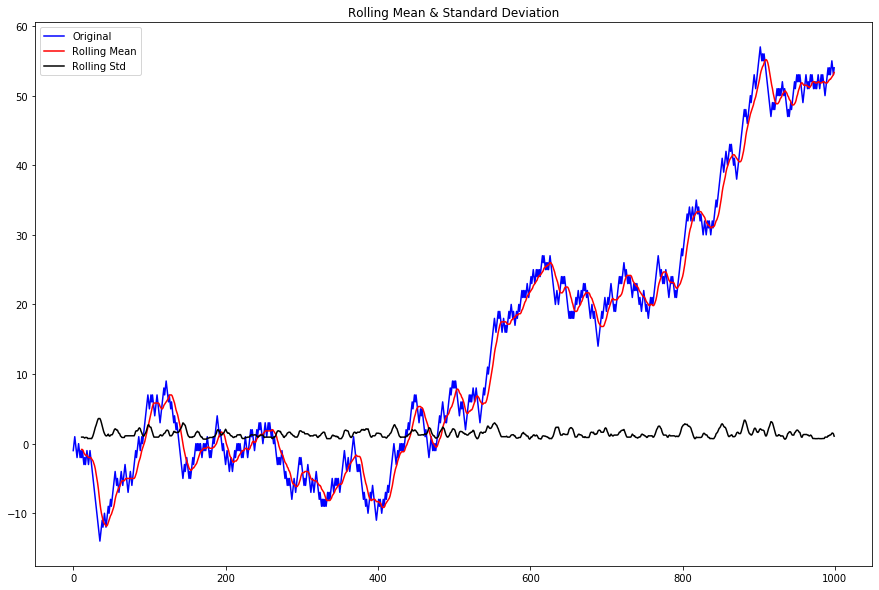

Results of Dickey-Fuller Test:
Test Statistic                   0.341605
p-value                          0.979175
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
Length: 7, dtype: float64


In [362]:
df_fuller(rw['value'], filename='random_walk_stationarity.png')

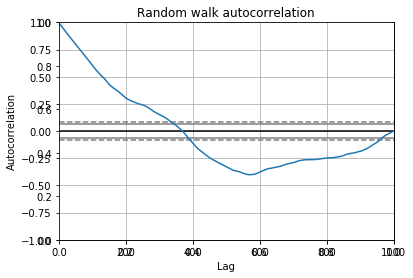

In [365]:
plt.title('Random walk autocorrelation')
autocorrelation_plot(rw)
plt.savefig('randomwalk_auto.png')
plt.show()

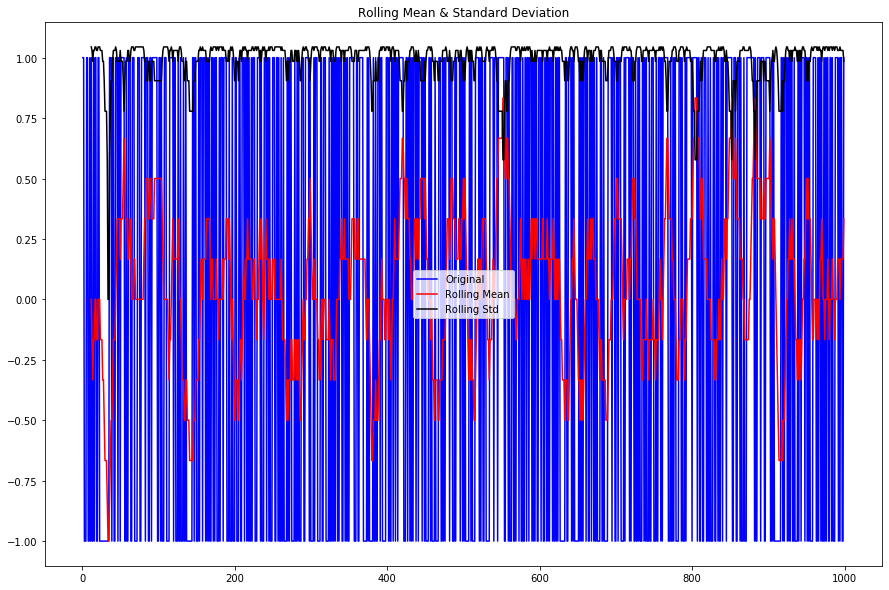

Results of Dickey-Fuller Test:
Test Statistic                 -31.084824
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
Length: 7, dtype: float64


In [363]:
df_fuller((rw['value'] - rw['value'].shift()).dropna())#, filename='random_walk_stationarity.png')